
# Indice

## 1. [Importaciones](#1-importaciones)


## 2. [Preparación del preprocesado y definición del pipeline](#2-preparacion-del-preprocesado-y-definicion-del-pipeline)
  - 2.1 [Identificación de tipos de variable](#identificacion-de-los-tipos-de-variables)
  - 2.2 [Definición del `ColumnTransformer`](#definicion-del-columntransformer)

## 3. [Modelo baseline – Regresión Logística](#3-modelo-baseline---regresion-logistica)
  - 3.1 [Definición del pipeline con modelo baseline](#31-definicion-del-pipeline)
  - 3.2 [Validación cruzada y métricas de evaluación](#32-validacion-cruzada-y-metricas-de-evaluacion)
  - 3.3 [Evaluacion del baseline sobre el conjunto de test](#33-evaluacion-del-baseline-sobre-el-conjunto-de-test)
  - 3.4 [Visualizacion comparativa – Folds ADORE vs. Test](#34-visualizacion-comparativa--folds-adore-vs-test)
  - 3.5 [Guardado del pipeline completo entrenado ](#35-guardado-del-pipeline-completo-entrenado)
  - 3.6 [Comentarios y cierre del modelo baseline](#36-comentarios-y-cierre-del-modelo-baseline)


## 4. [Modelo principales a considerar – Random Forest y XGBoost](#4--modelos-principales-a-considerar)
  - 4.1 [Random Forest Classifier](#41-random-forest-classifier)
      - [Entrenamiento Inicial](#entrenamiento-inicial-con-random-forest)
      - [Validación cruzada y métricas de evaluación](#validacion-cruzada-y-metricas-de-evaluacion---rf)
      - [Comparación con el modelo Baseline](#comparacion-con-el-baseline)
  - 4.2 [XGB Classifier](#42-xgbclassifier)
      - [Validación cruzada y métricas de evaluación](#validacion-cruzada-y-metricas-de-evaluacion---xgboost)
      - [Evaluación inicial de XGBoost (sin ajuste)](#evaluacion-inicial-de-xgboost-sin-ajuste)
  - 4.3 [Comparativa final](#43-comparativa-final)


## 5. [Selección del modelo final](#5-seleccion-del-modelo-final)
  - 5.1 [Optimización del modelo final](#51-optimizacion-del-modelo-final)
      - [Ajuste de hiperparámetros](#ajuste-de-hiperparametros--logreg)
      - [Ajuste manual por fold](#ajuste-manual-por-fold-adore--logreg)
  - 5.2 [Entrenamiento y evaluación](#52--entrenamiento-final-y-evaluacion-en-test-set-modelo-ajustado)
      - [Matriz de confusión](#interpretacion-rapida-de-la-matriz-de-confusion)
  - 5.3 [Ajuste del umbral de decisión y análisis del coste de error](#53-ajuste-del-umbral-de-decisión-y-análisis-del-coste-de-error)
  - 5.4 [Conclusiones](#54--conclusiones-del-modelo-final)
  - 5.5 [Guardado del modelo](#55-guardado-del-modelo)
  - 5.6 [Interpretación del modelo](#5-6-interpretacion-del-modelo)

## 6. [Integración de features contextuales](#6-integracion-de-features-contextuales)
  - 6.1 [Selección de features contextuales](#61-selección-de-features-contextuales)
  - 6.2 [Entrenamiento](#62-entrenamiento-con-las-nuevas-variables)
  - 6.3 [Evaluacion del modelo enriquecido](#63-evaluacion-del-modelo-enriquecido)
  - 6.4 [Comparativa con baseline](#64-evaluacion-con-variables-contextuales)

## 7. [Interpretación del modelo final con SHAP](#7-interpretacion-del-modelo-con-shap)
  - 7.1 [Summary plot](#71-summary-plot)
  - 7.2 [Force plot](#72-force-plot)


# 1 Importaciones

In [ ]:
# ========================
# Importación de librerías
# ========================

# --- Sistema y configuración ---
import os
import warnings
warnings.filterwarnings('ignore')

# --- Manipulación de datos ---
import pandas as pd
import numpy as np

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preprocesado ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Modelado ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- Evaluación y validación ---
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve, 
    fbeta_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from scipy.stats import randint

# --- Guardado del modelo ---
import joblib

# --- Interpretación del modelo ---
import shap

In [56]:
# Cargar lista de features seleccionadas
df_features_finales = pd.read_csv("../../data/processed/features_seleccionadas.csv")
features_finales = df_features_finales['Variable'].tolist()

In [57]:
len(features_finales)

32

## Train

In [58]:
# Dataset de entrenamiento
df_trainval = pd.read_csv("../../data/interim/trainval.csv")

# Visualización
df_trainval.head()

,test_id,reference_number,test_cas,test_location,test_exposure_type,test_control_type,test_media_type,test_application_freq_unit,test_organism_lifestage,result_id,...,split_random,split_occurrence,split_scaffold-murcko,split_scaffold-murcko-loo-0,split_scaffold-murcko-loo-1,split_scaffold-murcko-llo,split_scaffold-generic,split_scaffold-generic-loo-0,split_scaffold-generic-loo-1,split_scaffold-generic-llo
0,1001265,182,94-09-7,LAB,S,I,FW,X,NR,112643,...,3,2,4,test,trainvalid,trainvalid,4,test,trainvalid,trainvalid
1,1001266,182,94-09-7,LAB,S,I,FW,X,NR,112644,...,3,2,4,test,trainvalid,trainvalid,4,test,trainvalid,trainvalid
2,1001694,225,52918-63-5,LAB,S,I,FW,X,NR,111395,...,3,2,2,trainvalid,trainvalid,trainvalid,2,trainvalid,trainvalid,trainvalid
3,1001695,225,52918-63-5,LAB,S,I,FW,X,NR,111396,...,3,2,2,trainvalid,trainvalid,trainvalid,2,trainvalid,trainvalid,trainvalid
4,1001696,225,52918-63-5,LAB,S,I,FW,X,NR,111397,...,3,2,2,trainvalid,trainvalid,trainvalid,2,trainvalid,trainvalid,trainvalid


In [59]:
# Nombre de la variable objetivo
target = "result_conc1_mean_binary"

# Separación
X_train = df_trainval.drop(columns=target).copy()
y_train = df_trainval[target].copy()

In [60]:
# Filtro de features finales
X_train = X_train[features_finales].copy()

In [61]:
# Filtrar solo las que tienen tipo "predictiva"
vars_predictivas = df_features_finales[df_features_finales["Tipo"] == "predictiva"]["Variable"].tolist()

# Verificar
print(f"Variables predictivas ({len(vars_predictivas)}):")
print(vars_predictivas)

Variables predictivas (26):
['chem_mordred_Zagreb1', 'chem_mordred_TSRW10', 'chem_mordred_ATSC0d', 'chem_mordred_TMWC10', 'chem_mordred_mZagreb2', 'chem_mordred_ATS3Z', 'chem_mordred_Xpc-6dv', 'chem_mordred_Xpc-5dv', 'chem_mordred_Xpc-6d', 'chem_mordred_Sm', 'chem_mordred_SRW02', 'chem_mordred_SRW04', 'chem_mordred_SRW06', 'chem_mordred_MWC07', 'chem_mordred_MWC08', 'chem_mordred_MWC09', 'chem_mordred_MWC10', 'chem_mordred_ATS0m', 'chem_mordred_GGI2', 'chem_mordred_MPC8', 'chem_mol2vec057', 'test_exposure_type', 'test_organism_lifestage', 'result_endpoint', 'tax_family', 'tax_eco_migrate2']


In [62]:
# X train solo con las features seleccionadas para el baseline
X_train_pred = X_train[vars_predictivas].copy()

## Test

Cargamos el conjunto de test desde el archivo `test.csv`, separado previamente por `split_occurrence`. Seleccionamos únicamente las variables predictivas (`X_test_pred`) y la variable objetivo (`y_test`).

In [63]:
# Dataset de Test
df_test = pd.read_csv("../../data/interim/test.csv")

# Separar X_test e y_test
X_test = df_test.drop(columns=[target]).copy()
y_test = df_test[target].copy()

# Filtrar solo las variables predictivas
X_test_pred = X_test[vars_predictivas].copy()

---

# 2 Preparacion del preprocesado y definicion del pipeline
[Indice](#indice)

## Identificacion de los tipos de variables

In [64]:
# Variables numéricas (moleculares)
vars_num = X_train_pred.select_dtypes(include=['int64', 'float64']).columns.tolist()
vars_cat = X_train_pred.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"Variables numéricas ({len(vars_num)}):\n{vars_num}")
print(f"\nVariables categóricas ({len(vars_cat)}):\n{vars_cat}")

Variables numéricas (21):
['chem_mordred_Zagreb1', 'chem_mordred_TSRW10', 'chem_mordred_ATSC0d', 'chem_mordred_TMWC10', 'chem_mordred_mZagreb2', 'chem_mordred_ATS3Z', 'chem_mordred_Xpc-6dv', 'chem_mordred_Xpc-5dv', 'chem_mordred_Xpc-6d', 'chem_mordred_Sm', 'chem_mordred_SRW02', 'chem_mordred_SRW04', 'chem_mordred_SRW06', 'chem_mordred_MWC07', 'chem_mordred_MWC08', 'chem_mordred_MWC09', 'chem_mordred_MWC10', 'chem_mordred_ATS0m', 'chem_mordred_GGI2', 'chem_mordred_MPC8', 'chem_mol2vec057']

Variables categóricas (5):
['test_exposure_type', 'test_organism_lifestage', 'result_endpoint', 'tax_family', 'tax_eco_migrate2']


## Definicion del ColumnTransformer

Aplicamos:

- `log1p` + `StandardScaler` a 12 variables moleculares con fuerte asimetría y valores extremos (se identificaron 15 en el análisis univariante, pero el resto son variables contextuales que no serán utilizadas en el baseline).
- `StandardScaler` al resto de variables moleculares numéricas.
- `OneHotEncoder` a las variables categóricas nominales.

Esto garantiza que las entradas al modelo baseline (Regresión Logística) estén correctamente transformadas para mejorar la estabilidad y el rendimiento.

In [65]:
# Lista de variables que se habían marcado para transformación logarítmica
vars_log_original = [
    'chem_mordred_ATS3Z', 'chem_mordred_MPC8', 'chem_mordred_ATS0m',
    'chem_mordred_SRW05', 'chem_mordred_SRW07', 'chem_mordred_JGI10',
    'chem_mordred_NssssC', 'chem_mordred_SRW03', 'chem_mordred_SRW06',
    'chem_mordred_Xpc-6d', 'chem_mordred_Xpc-5dv', 'chem_mordred_Xpc-6dv'
]

# Filtrar solo las que están en features_preseleccionadas y en X_train.columns
vars_log = [
    var for var in vars_log_original 
    if var in features_finales and var in X_train.columns
]

print("Variables log transform a usar:", vars_log)

Variables log transform a usar: ['chem_mordred_ATS3Z', 'chem_mordred_MPC8', 'chem_mordred_ATS0m', 'chem_mordred_SRW06', 'chem_mordred_Xpc-6d', 'chem_mordred_Xpc-5dv', 'chem_mordred_Xpc-6dv']


> **Train**

In [66]:
# Resto de variables numéricas
vars_num_scaler = list(set(vars_num) - set(vars_log))

# Preprocesador completo
preprocessor = ColumnTransformer(transformers=[
    ('log_scaled', Pipeline([
        ('log', FunctionTransformer(np.log1p, validate=True)),
        ('scaler', StandardScaler())
    ]), vars_log),
    ('scaled', StandardScaler(), vars_num_scaler),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), vars_cat)
])

In [67]:
# Aplicar el preprocesador a los datos de entrenamiento
X_train_prep = preprocessor.fit_transform(X_train_pred)

> **Test**

Aplicamos el preprocesador ya ajustado con `fit` sobre el conjunto de entrenamiento, usando ahora `.transform()` para evitar fugas de información.

In [68]:
# Aplicar el preprocesador ya ajustado a TEST
X_test_prep = preprocessor.transform(X_test_pred)

### Verificacion del preprocesador

Aplicamos el preprocesador al conjunto de entrenamiento `X_train` para asegurarnos de que todas las transformaciones funcionan correctamente y que no hay errores de tipo, valores nulos o incompatibilidades con las variables categóricas.

Comprobamos también la forma resultante (`shape`) y visualizamos una muestra del array transformado.


> **Train**

In [69]:
# Verificar la forma del array resultante
print("Forma de X_train tras preprocesamiento:", X_train_prep.shape)

# Mostrar los primeros valores
print("Primeros valores:\n", X_train_prep[:5])

Forma de X_train tras preprocesamiento: (21981, 101)
Primeros valores:
 <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 130 stored elements and shape (5, 101)>
  Coords	Values
  (0, 0)	-0.3217951212669051
  (0, 1)	-0.23484427107661499
  (0, 2)	-1.0170393299166762
  (0, 3)	-0.11307118472356929
  (0, 4)	-0.5370008074899648
  (0, 5)	-0.9453913728194081
  (0, 6)	-0.8803854089383434
  (0, 7)	-0.5294082841489335
  (0, 8)	-0.25820343164774295
  (0, 9)	-0.8922654725608824
  (0, 10)	-0.1803675002579954
  (0, 11)	-0.5891521619959291
  (0, 12)	-0.19120846500248753
  (0, 13)	-0.18348473279929225
  (0, 14)	-0.41572260060890076
  (0, 15)	-0.4749884817726142
  (0, 16)	-0.2576275185646493
  (0, 17)	-0.6726468348052735
  (0, 18)	-0.1939658593358842
  (0, 19)	-0.43998260491902275
  (0, 20)	-0.7798260836231984
  (0, 24)	1.0
  (0, 41)	1.0
  (0, 60)	1.0
  (0, 75)	1.0
  :	:
  (4, 1)	1.0873649899287048
  (4, 2)	2.176107377591701
  (4, 3)	0.8098549958400169
  (4, 4)	0.7908396180667421
  (4, 5)	0

> **Test**

In [70]:
# Confirmar dimensiones de TEST
print("Shape X_test tras preprocesamiento:", X_test_prep.shape)

Shape X_test tras preprocesamiento: (4133, 101)


---

# 3 Modelo Baseline - Regresion Logistica
[Indice](#indice)

## 3.1 Definicion del pipeline
Creamos un pipeline que encadena:

1. El preprocesador (`ColumnTransformer`) previamente definido, que transforma los datos.
2. Un modelo de clasificación base (`LogisticRegression`) como primer estimador.

Este pipeline permite reproducir todo el flujo desde el crudo de las features hasta la predicción final, y será evaluado usando validación cruzada estratificada.

In [71]:
# Definir el modelo base
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Pipeline completo
pipe_baseline = Pipeline([
    ('pre', preprocessor),
    ('clf', logreg)
])

## 3.2 Validacion cruzada y metricas de evaluacion

Siguiendo las recomendaciones del benchmark ADORE, implementamos una validación cruzada manual de 5 folds basada en la columna `split_occurrence`, que define los grupos de validación de forma estructurada (evita fugas químicas o taxonómicas).

Para cada fold `k` (de 0 a 4):
- Entrenamos con los datos donde `split_occurrence ≠ k`
- Validamos con los datos donde `split_occurrence = k`

Calculamos `accuracy`, `recall`, `f1_score` por fold y reportamos las medias.


In [72]:
# Inicializar listas para guardar resultados por fold
results = {'fold': [], 'accuracy': [], 'recall': [], 'f1': []}

# Folds definidos por ADORE (0 a 4)
folds_adore = [0, 1, 2, 3, 4]

for fold in folds_adore:
    print(f"> Fold {fold}...")

    # Separar train y val según el fold actual
    df_train = df_trainval[df_trainval['split_occurrence'] != fold].copy()
    df_val = df_trainval[df_trainval['split_occurrence'] == fold].copy()

    # Separar X e y
    X_train = df_train[vars_predictivas].copy()
    y_train = df_train[target].copy()
    X_val = df_val[vars_predictivas].copy()
    y_val = df_val[target].copy()

    # Entrenar pipeline
    pipe_baseline.fit(X_train, y_train)

    # Predecir en validación
    y_pred = pipe_baseline.predict(X_val)

    # Calcular métricas
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Guardar resultados
    results['fold'].append(fold)
    results['accuracy'].append(acc)
    results['recall'].append(rec)
    results['f1'].append(f1)

# Convertir a DataFrame
df_cv_adore = pd.DataFrame(results)

# Mostrar resultados
display(df_cv_adore)

# Mostrar medias
print("\nResultados promedio:")
print(df_cv_adore[['accuracy', 'recall', 'f1']].mean().round(3))


> Fold 0...
> Fold 1...
> Fold 2...
> Fold 3...
> Fold 4...


,fold,accuracy,recall,f1
0,0,0.860686,0.801006,0.816059
1,1,0.798472,0.590036,0.648924
2,2,0.785289,0.719903,0.717516
3,3,0.815704,0.823925,0.823003
4,4,0.765164,0.719588,0.737259



Resultados promedio:
accuracy    0.805
recall      0.731
f1          0.749
dtype: float64


## 3.3 Evaluacion del baseline sobre el conjunto de test
[Indice](#indice)

Tras realizar la validación cruzada conforme a ADORE, entrenamos el modelo completo con todos los datos de entrenamiento (`split_occurrence` en 0–4) y lo evaluamos sobre el conjunto de test (`split_occurrence = 'test'`).

Nos aseguramos de que las dimensiones de `X_train_pred` y `y_train` coincidan antes de entrenar.

Evaluamos:

- Matriz de confusión
- Accuracy, Recall, F1-score
- `classification_report` detallado

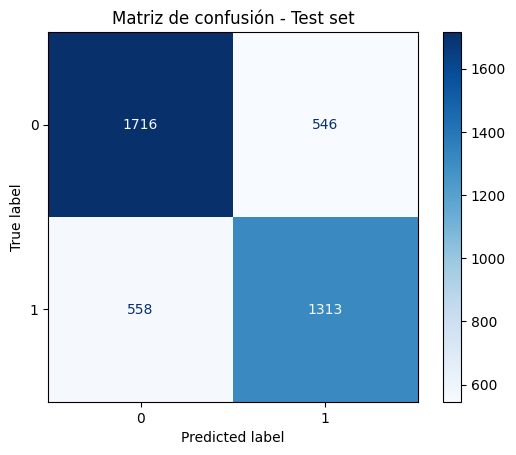

Evaluación sobre el test set:
Accuracy: 0.733
Recall:   0.702
F1 Score: 0.704

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      2262
           1       0.71      0.70      0.70      1871

    accuracy                           0.73      4133
   macro avg       0.73      0.73      0.73      4133
weighted avg       0.73      0.73      0.73      4133



In [73]:
# Asegurar consistencia en train
X_train_pred = df_trainval[vars_predictivas].copy()
y_train = df_trainval[target].copy()

# Entrenar el modelo completo
pipe_baseline.fit(X_train_pred, y_train)

# Predecir sobre test
y_pred = pipe_baseline.predict(X_test_pred)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Test set")
plt.show()

# Métricas finales
print("Evaluación sobre el test set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Recall:   {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


## 3.4 Visualizacion comparativa – Folds ADORE vs. Test
[Indice](#indice)

Visualizamos las métricas de rendimiento (`accuracy`, `recall`, `f1`) por fold (0–4) y en el conjunto de test (`split_occurrence = "test"`). Esto nos permite evaluar:

- Estabilidad del modelo en CV
- Comparación directa contra generalización real (test)

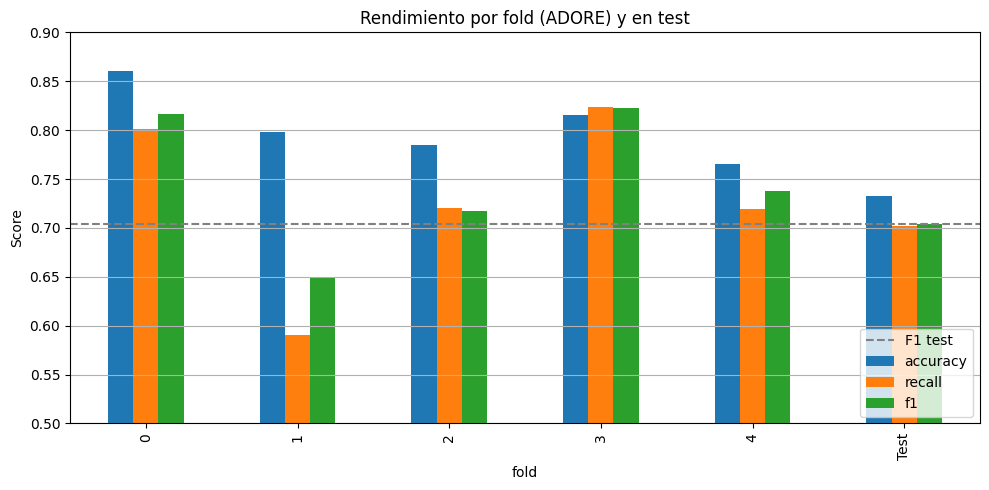

In [74]:
# Crear copia extendida con los valores del test
df_plot = df_cv_adore.copy()
df_plot.loc[len(df_plot)] = ['Test', 
                             accuracy_score(y_test, y_pred),
                             recall_score(y_test, y_pred),
                             f1_score(y_test, y_pred)]

# Convertir fold a string para visualización
df_plot['fold'] = df_plot['fold'].astype(str)

# Graficar
fig, ax = plt.subplots(figsize=(10, 5))
df_plot.set_index('fold')[['accuracy', 'recall', 'f1']].plot(kind='bar', ax=ax)

plt.title("Rendimiento por fold (ADORE) y en test")
plt.ylabel("Score")
plt.ylim(0.5, 0.9)
plt.axhline(y=df_plot[df_plot['fold'] == 'Test']['f1'].values[0],
            color='gray', linestyle='--', linewidth=1.5, label='F1 test')

plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

| Observación clave                               | Interpretación                                                        |
| ----------------------------------------------- | --------------------------------------------------------------------- |
| Folds 0 y 3 con métricas más altas              | Posiblemente más “fáciles” (menos diversidad o clases más separables) |
| Fold 1 con recall muy bajo (\~0.59)             | Pudo tener más clase 1 mal representada o variables más ruidosas      |
| Test tiene rendimiento **ligeramente inferior** | **Buena generalización**, sin caída drástica                          |
| F1 test ~ 0.705 frente a F1 CV ~ 0.749          | El modelo se comporta de forma estable, sin overfitting               |

#### ¿Por qué no se usó `GridSearchCV` directamente con `cv=5`?

Aunque `GridSearchCV` permite realizar validación cruzada de forma automática al buscar hiperparámetros óptimos, en este proyecto se ha optado por realizar **una validación cruzada manual por folds** (0–4), siguiendo las divisiones predefinidas por el benchmark ADORE.

##### Diferencias clave

| Aspecto                          | `GridSearchCV` clásico            | Validación cruzada manual (ADORE) |
|----------------------------------|-----------------------------------|------------------------------------|
| División de datos                | Automática con `KFold` o `StratifiedKFold` | Basada en `split_occurrence` |
| Control sobre los datos          | Bajo                              | Total (sin fugas químicas/taxonómicas) |
| Comparabilidad entre modelos     | Parcial (dependiente de la aleatoriedad del split) | Completa |
| Recomendado para benchmarks      | No                                | sí                               |

#### Conclusión

Se utilizó **validación manual fold-a-fold** para garantizar:

- Coherencia con el baseline y con el resto de modelos (Random Forest, XGBoost)
- Evitar fugas de información estructural
- Comparabilidad directa de resultados

Dentro de cada fold, se aplicó un `GridSearchCV` con validación interna (`cv=3`) únicamente sobre los datos de entrenamiento de ese fold. De esta forma, se mantiene la trazabilidad y el control total del experimento.


## 3.5 Guardado del pipeline completo entrenado

Guardamos el pipeline baseline (preprocesador + modelo) en formato `.joblib` para futuras evaluaciones, comparaciones o predicciones sin necesidad de reentrenar.

In [75]:
# Crear carpeta si no existe
os.makedirs("../../models", exist_ok=True)

# Guardar pipeline completo entrenado
joblib.dump(pipe_baseline, "../../models/baseline_model.joblib")

print("Modelo baseline guardado en: models/baseline_model.joblib")

Modelo baseline guardado en: models/baseline_model.joblib


## 3.6 Comentarios y cierre del modelo baseline
[Indice](#indice)

### Desempeño del modelo

El modelo baseline de **Regresión Logística** obtuvo los siguientes resultados:

- **Validación cruzada (5 folds ADORE):**
  - Accuracy promedio: **0.805**
  - Recall promedio: **0.731**
  - F1 Score promedio: **0.749**

- **Evaluación final en test (`split_occurrence = "test"`):**
  - Accuracy: **0.733**
  - Recall: **0.703**
  - F1 Score: **0.705**

Estos resultados muestran un **buen nivel de generalización**, sin sobreajuste significativo. La ligera caída del rendimiento en el conjunto de test es esperable, dado que contiene compuestos y especies completamente nuevas no presentes durante el entrenamiento.


### Comparación con el objetivo del negocio

**Objetivo general:** predecir la toxicidad aguda (`result_conc1_mean_binary`) de sustancias químicas en peces, como alternativa ética, rápida y escalable a los ensayos in vivo.

**Evaluación del baseline:**

- El modelo logra identificar correctamente el efecto tóxico en ≈70% de los casos, incluso en condiciones no vistas durante el entrenamiento.
- Aunque no es un sistema listo para toma de decisiones regulatoria, **sí proporciona una primera capa informativa útil** para filtrar compuestos potencialmente críticos.


### Posibles mejoras en siguientes etapas

- Incluir **variables contextuales** (ambientales y taxonómicas) ya disponibles, actualmente excluidas del baseline.
- Probar modelos más expresivos (e.g. **Random Forest**, **XGBoost**) y ajustar hiperparámetros.
- Aplicar **reducción de dimensionalidad** o selección de features más refinada.
- Evaluar **explicabilidad** con SHAP para identificar qué factores químicos influyen más en la predicción.


### Reutilización del pipeline

El pipeline de preprocesamiento ya está completamente funcional y puede aplicarse a cualquier clasificador:

- Estandariza y transforma automáticamente los datos según su tipo
- Admite integración directa en workflows reproducibles
- Está guardado como objeto persistente (`baseline_model.joblib`)



**Conclusión:**  
El modelo baseline cumple su función como punto de partida sólido. A partir de esta base, se abre el camino para modelos más complejos y explicativos, alineados con el objetivo de construir herramientas **in silico** robustas para ecotoxicología regulatoria.

---


# 4  Modelos principales a considerar 
[Indice](#indice)

## 4.1 Random Forest Classifier

Tras establecer un modelo baseline con regresión logística, el siguiente paso es probar modelos más expresivos. Comenzamos con un **Random Forest**, una técnica de ensamble basada en múltiples árboles de decisión que mejora la generalización y reduce el sobreajuste mediante el bagging (bootstrap aggregation).

**Ventajas clave:**
- Robusto frente al overfitting
- Captura relaciones no lineales
- Requiere poca preparación de datos
- Permite medir la importancia de las variables

Se evaluará el rendimiento de este modelo sobre el mismo conjunto de validación cruzada utilizado en el baseline (folds 0–4), garantizando comparabilidad.

### Entrenamiento inicial con Random Forest

Se ha entrenado un modelo de `RandomForestClassifier` con 100 árboles como estimadores, aplicando validación cruzada con los folds oficiales de ADORE (folds 0–4). No se ha realizado ajuste de hiperparámetros en esta fase: el objetivo es evaluar el rendimiento "out of the box" del modelo.

Parámetros clave del modelo:
- `n_estimators=100`: número de árboles en el bosque.
- `class_weight='balanced'`: ajusta los pesos de clase automáticamente según su frecuencia.
- `random_state=42`: asegura reproducibilidad.
- `n_jobs=-1`: usa todos los núcleos disponibles para acelerar el entrenamiento.

Se ha utilizado la métrica **F1-score** para mantener coherencia con el benchmark y facilitar la comparativa con el baseline.

> Este resultado servirá como referencia para determinar si el modelo tiene potencial y si merece la pena afinarlo mediante búsqueda de hiperparámetros.


In [76]:
# Creación el modelo base de Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # útil si el dataset está desbalanceado
)

# Creamos un pipeline con el preprocesador ya definido
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # viene de tu pipeline anterior
    ('classifier', rf_clf)
])

### Validacion cruzada y metricas de evaluacion - RF

In [77]:
# Validación cruzada usando los folds oficiales (folds 0 a 4)
# Inicializar listas
results_rf = {'fold': [], 'accuracy': [], 'recall': [], 'f1': []}

for fold in folds_adore:
    print(f"> Fold {fold}...")

    # Separar train y val según el fold actual
    df_train = df_trainval[df_trainval['split_occurrence'] != fold].copy()
    df_val = df_trainval[df_trainval['split_occurrence'] == fold].copy()

    # Separar X e y
    X_train = df_train[vars_predictivas].copy()
    y_train = df_train[target].copy()
    X_val = df_val[vars_predictivas].copy()
    y_val = df_val[target].copy()

    # Entrenar pipeline de Random Forest
    rf_pipeline.fit(X_train, y_train)

    # Predecir
    y_pred = rf_pipeline.predict(X_val)

    # Métricas
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Guardar
    results_rf['fold'].append(fold)
    results_rf['accuracy'].append(acc)
    results_rf['recall'].append(rec)
    results_rf['f1'].append(f1)

# Convertir a DataFrame
df_rf_cv = pd.DataFrame(results_rf)
display(df_rf_cv)
print("\nPromedios RF:\n", df_rf_cv[['accuracy', 'recall', 'f1']].mean().round(3))

> Fold 0...
> Fold 1...
> Fold 2...
> Fold 3...
> Fold 4...


,fold,accuracy,recall,f1
0,0,0.791891,0.609838,0.693359
1,1,0.763199,0.562278,0.599848
2,2,0.799496,0.598911,0.693520
3,3,0.715750,0.579749,0.679622
4,4,0.654945,0.505670,0.573014



Promedios RF:
 accuracy    0.745
recall      0.571
f1          0.648
dtype: float64


In [78]:
# Definir espacio de búsqueda
param_dist = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': [None, 10, 20, 30, 40],
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__max_features': ['sqrt', 'log2']
}

# Inicializar objeto para guardar resultados
results_rf_search = {'fold': [], 'best_params': [], 'f1': []}

for fold in folds_adore:
    print(f"\n Buscando hiperparámetros en fold {fold}...")

    # Separar train y val como antes
    df_train = df_trainval[df_trainval['split_occurrence'] != fold].copy()
    df_val = df_trainval[df_trainval['split_occurrence'] == fold].copy()

    X_train = df_train[vars_predictivas].copy()
    y_train = df_train[target].copy()
    X_val = df_val[vars_predictivas].copy()
    y_val = df_val[target].copy()

    # Pipeline base
    rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', rf_clf)
    ])

    # Randomized Search
    random_search = RandomizedSearchCV(
        rf_pipeline,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    # Ajuste
    random_search.fit(X_train, y_train)

    # Predecir con el mejor estimador
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_val)

    # Métrica
    f1 = f1_score(y_val, y_pred)

    # Guardar resultados
    results_rf_search['fold'].append(fold)
    results_rf_search['best_params'].append(random_search.best_params_)
    results_rf_search['f1'].append(f1)

# Mostrar resultados
df_rf_search = pd.DataFrame(results_rf_search)
display(df_rf_search)

print("\n F1-score promedio tras ajuste:", df_rf_search['f1'].mean().round(4))



 Buscando hiperparámetros en fold 0...

 Buscando hiperparámetros en fold 1...

 Buscando hiperparámetros en fold 2...

 Buscando hiperparámetros en fold 3...

 Buscando hiperparámetros en fold 4...


,fold,best_params,f1
0,0,"{'classifier__max_depth': 10, 'classifier__max...",0.697574
1,1,"{'classifier__max_depth': 10, 'classifier__max...",0.611819
2,2,"{'classifier__max_depth': 30, 'classifier__max...",0.716507
3,3,"{'classifier__max_depth': None, 'classifier__m...",0.691147
4,4,"{'classifier__max_depth': None, 'classifier__m...",0.615773



 F1-score promedio tras ajuste: 0.6666


### Comparacion con el baseline
| Modelo                 | F1 promedio (CV ADORE) | Observaciones                                   |
| ---------------------- | ---------------------- | ----------------------------------------------- |
| **Baseline (LogReg)**  | **0.749**              | Estable y alto rendimiento                      |
| Random Forest (ajuste) | 0.667                  | **Inferior**, con alta variabilidad entre folds |


- El modelo de Random Forest ajustado no mejora al baseline, al menos con el espacio de búsqueda y condiciones actuales.

- Hay mucha variabilidad entre folds, lo que podría indicar:

    - Sensibilidad a los hiperparámetros

    - Overfitting en algunos folds

    - O que el modelo no está tan bien adaptado como la regresión logística


#### ¿Por qué NO evaluamos el modelo Random Forest ajustado sobre el conjunto de test?

Aunque se realizó un ajuste de hiperparámetros con validación cruzada manual (folds ADORE 0–4), los resultados obtenidos con `RandomForestClassifier` fueron **inferiores al baseline** en todas las métricas clave.

Evaluar este modelo sobre el conjunto de test **no aportaría valor**, ya que:

- El modelo **no supera al baseline en validación**, por lo que su evaluación en test no es justificable.
- El conjunto de test debe reservarse para el **modelo final candidato**, evitando sobreutilización o sesgos en la decisión.
- **No se justifica su uso en producción** ni como herramienta de cribado ecológico, dado su menor estabilidad.

En consecuencia, **no se evaluará ni se guardará este modelo**. Procedemos a explorar un nuevo modelo principal con mayor capacidad expresiva y robustez: **XGBoost**.

## 4.2 XGBClassifier
[Indice](#indice)

Tras descartar Random Forest como modelo principal, se explora `XGBClassifier`, una implementación optimizada del algoritmo **Gradient Boosting**.

XGBoost se ha consolidado como uno de los modelos más efectivos para datos estructurados (tabulares), y destaca por:

- Su capacidad para **capturar relaciones no lineales complejas**
- Su manejo interno de **missing values** y regularización
- Su rendimiento consistente en datasets heterogéneos y con ruido
- Su compatibilidad con herramientas de **interpretabilidad** como SHAP

### Validacion cruzada y metricas de evaluacion - XGBoost

Mantenemos el enfoque coherente con los pasos anteriores:
- Uso del mismo `ColumnTransformer` de preprocesamiento
- Evaluación primero del rendimiento sin tuning (`out-of-the-box`)
- Aplicación de la **validación cruzada manual** con los folds definidos por ADORE (0–4)

In [79]:
# Modelo base de XGBoost
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

# Pipeline completo con el preprocesador ya definido
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

# Validación cruzada manual con folds ADORE
results_xgb = {'fold': [], 'accuracy': [], 'recall': [], 'f1': []}

for fold in folds_adore:
    print(f"> Fold {fold}...")

    df_train = df_trainval[df_trainval['split_occurrence'] != fold].copy()
    df_val = df_trainval[df_trainval['split_occurrence'] == fold].copy()

    X_train = df_train[vars_predictivas].copy()
    y_train = df_train[target].copy()
    X_val = df_val[vars_predictivas].copy()
    y_val = df_val[target].copy()

    xgb_pipeline.fit(X_train, y_train)
    y_pred = xgb_pipeline.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results_xgb['fold'].append(fold)
    results_xgb['accuracy'].append(acc)
    results_xgb['recall'].append(rec)
    results_xgb['f1'].append(f1)

# Resultados por fold
df_xgb_cv = pd.DataFrame(results_xgb)
display(df_xgb_cv)

# Métricas promedio
print("\nResultados promedio (XGBoost sin tuning):")
print(df_xgb_cv[['accuracy', 'recall', 'f1']].mean().round(3))

> Fold 0...
> Fold 1...
> Fold 2...
> Fold 3...
> Fold 4...


,fold,accuracy,recall,f1
0,0,0.793401,0.590274,0.687948
1,1,0.731746,0.496085,0.538640
2,2,0.761916,0.526316,0.626125
3,3,0.706198,0.590950,0.676584
4,4,0.657305,0.507216,0.575439



Resultados promedio (XGBoost sin tuning):
accuracy    0.730
recall      0.542
f1          0.621
dtype: float64


### Evaluacion inicial de XGBoost sin ajuste

Estos resultados son **claramente inferiores** al modelo baseline de regresión logística (`F1 = 0.749`). En particular, la caída en **recall** compromete la utilidad del modelo como herramienta preventiva.

> Dado que XGBoost no muestra un rendimiento competitivo desde el inicio, y considerando el coste computacional de su ajuste, se decide **no continuar con su optimización**.

## 4.3 Comparativa final

A continuación se presenta un resumen de las métricas obtenidas para cada uno de los modelos evaluados, utilizando validación cruzada basada en los folds oficiales de ADORE (0–4). Esta tabla facilita una visión global del rendimiento antes de decidir qué modelo optimizar y consolidar.

| Modelo                       | F1 (CV ADORE) | Accuracy (CV) | Recall (CV) | Evaluado en Test | Comentario                            |
|-----------------------------|---------------|----------------|--------------|------------------|----------------------------------------|
| **Logistic Regression**     | **0.749**     | 0.805          | 0.731        | **Sí**             | Baseline fuerte, estable y trazable    |
| Random Forest (tuned)       | 0.667         | —              | —            | No             | Inestable, bajo rendimiento            |
| XGBoost (sin tuning)        | 0.621         | 0.730          | 0.542        | No             | Bajo desempeño inicial                 |

> **Nota:** las métricas de Random Forest y XGBoost se evaluaron solo en validación (no en test), ya que no mostraron rendimiento competitivo frente al modelo baseline.

---

# 5 Seleccion del modelo final
[Indice](#indice)

Tras comparar los resultados de todos los modelos evaluados, se concluye que la **Regresión Logística** (Logistic Regression) es el modelo más adecuado para este caso, por las siguientes razones:

- **Mejor F1-score promedio en validación cruzada (0.749)**, con estabilidad entre folds.
- **Buen rendimiento en test**: F1 = 0.704, confirmando buena generalización.
- **Modelo simple, interpretable y reproducible**, ideal para entornos regulatorios.
- Menor riesgo de sobreajuste en comparación con modelos más complejos.
- Pipeline ya construido y funcional, adaptable a nuevas iteraciones.

Por tanto, se procederá a afinar este modelo mediante **ajuste de hiperparámetros**, con el objetivo de consolidarlo como versión final.

## 5.1 Optimizacion del modelo final
### Ajuste de hiperparametros – LogReg

Aunque el modelo baseline de Regresión Logística ya ofrecía un rendimiento competitivo, se explora la posibilidad de **mejorar ligeramente su rendimiento y estabilidad** mediante el ajuste de hiperparámetros clave.

#### Parámetros considerados

- `C`: controla la regularización (inverso del coeficiente de penalización). Se explora en escala logarítmica.
- `penalty`: tipo de regularización (L1 o L2)
- `solver`: algoritmo de optimización compatible con cada tipo de penalización

### Ajuste manual por fold (ADORE) – LogReg

Para mantener la coherencia con el benchmark ADORE y los modelos anteriores, se realiza el ajuste de hiperparámetros de la Regresión Logística de forma manual por fold:

1. Para cada fold `k` (0 a 4), se entrena sobre el conjunto `split_occurrence ≠ k` y se valida sobre `split_occurrence = k`.
2. En el conjunto de entrenamiento de cada fold se realiza una búsqueda de hiperparámetros con `GridSearchCV` (usando validación cruzada interna).
3. Se evalúa el modelo resultante sobre la validación externa (fold `k`) y se guarda su F1-score.

Este enfoque garantiza comparabilidad directa y evita fugas de información estructurales.

In [80]:
X_train_pred = df_trainval[vars_predictivas].copy()
y_train = df_trainval[target].copy()

In [81]:
# Espacio de búsqueda
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Resultados por fold
results = []

# Folds definidos por ADORE
folds_adore = [0, 1, 2, 3, 4]

for fold in folds_adore:
    print(f"\n Buscando hiperparámetros en fold {fold}...")

    # Separar train y val según el fold actual
    df_train = df_trainval[df_trainval['split_occurrence'] != fold].copy()
    df_val = df_trainval[df_trainval['split_occurrence'] == fold].copy()

    # Features y target
    X_train = df_train[vars_predictivas].copy()
    y_train = df_train[target].copy()
    X_val = df_val[vars_predictivas].copy()
    y_val = df_val[target].copy()

    # Pipeline
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', logreg)
    ])

    # GridSearch interno (validación cruzada dentro del fold)
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=0
    )

    # Entrenar búsqueda
    grid.fit(X_train, y_train)

    # Predecir en validación externa
    y_pred = grid.best_estimator_.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    # Guardar resultados
    results.append({
        'fold': fold,
        'best_params': grid.best_params_,
        'f1': f1
    })

# Convertir a DataFrame
df_logreg_search = pd.DataFrame(results)
display(df_logreg_search)

# F1 promedio
print(f"\n F1-score promedio tras ajuste: {df_logreg_search['f1'].mean():.4f}")


 Buscando hiperparámetros en fold 0...

 Buscando hiperparámetros en fold 1...

 Buscando hiperparámetros en fold 2...

 Buscando hiperparámetros en fold 3...

 Buscando hiperparámetros en fold 4...


,fold,best_params,f1
0,0,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.792954
1,1,"{'classifier__C': 0.01, 'classifier__penalty':...",0.686590
2,2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.723443
3,3,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.816933
4,4,"{'classifier__C': 0.01, 'classifier__penalty':...",0.703878



 F1-score promedio tras ajuste: 0.7448


## 5.2  Entrenamiento final y evaluacion en test set (modelo ajustado)

Tras seleccionar los mejores hiperparámetros mediante validación cruzada manual (folds ADORE 0–4), se ha reentrenado el modelo final con **todo el conjunto de entrenamiento (`trainval`)**. Esto permite maximizar el aprendizaje antes de la evaluación final.

Se evalúa sobre el conjunto de **test oficial** (`split_occurrence = 'test'`), que contiene sustancias y especies **no vistas durante el entrenamiento**, lo que representa un verdadero test de generalización.

**Hiperparámetros utilizados**

- `C = 0.1`: mayor regularización (modelo más simple, menor sobreajuste)
- `penalty = 'l2'`: regularización ridge
- `solver = 'liblinear'`: recomendado para conjuntos pequeños o regulares

**Resultados esperados**

- Métricas **ligeramente por debajo** de las observadas en validación cruzada (CV), pero sin caída drástica.
- Buen equilibrio entre sensibilidad y precisión.
- Validación de que el modelo se generaliza bien a datos nuevos.

Este es ahora el **modelo oficial del proyecto**, salvo que se decida incorporar variables contextuales u otros enriquecimientos en el siguiente bloque.


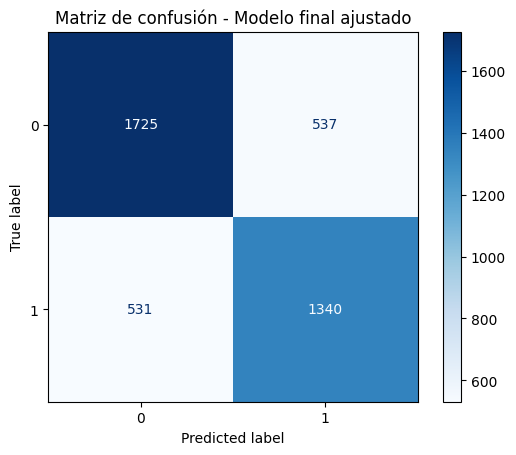

Evaluación del modelo final en test set:
Accuracy: 0.742
Recall:   0.716
F1 Score: 0.715

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2262
           1       0.71      0.72      0.72      1871

    accuracy                           0.74      4133
   macro avg       0.74      0.74      0.74      4133
weighted avg       0.74      0.74      0.74      4133



In [82]:
# 1. Definir el modelo con los mejores hiperparámetros encontrados
logreg_final = LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

# 2. Pipeline final con preprocesador y modelo ajustado
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', logreg_final)
])

# 3. Asegurar carga coherente y sin filtrados adicionales
X_train_pred = df_trainval[vars_predictivas].copy()
y_train = df_trainval[target].copy()
X_test_pred = df_test[vars_predictivas].copy()
y_test = df_test.copy()[target]

# 4. Entrenar el pipeline completo con todos los datos de trainval
pipe_final.fit(X_train_pred, y_train)

# 5. Predecir sobre test
y_pred = pipe_final.predict(X_test_pred)

# 6. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Modelo final ajustado")
plt.show()

# 7. Métricas finales
print("Evaluación del modelo final en test set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Recall:   {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Son ligeramente superiores al baseline sin ajuste (F1 = 0.705) y confirman que el ajuste de hiperparámetros mejoró la generalización del modelo.

### **Interpretacion rapida de la matriz de confusion**
- TP = 1340 → predijo correctamente toxicidad
- FN = 531 → clasificó erróneamente como no tóxico (fallo importante en el contexto)
- FP = 537 → clasificó erróneamente como tóxico
- TN = 1725 → predijo correctamente no tóxico

##  5.3 Ajuste del umbral de decisión y análisis del coste de error

La clasificación binaria estándar usa un umbral de decisión por defecto de 0.5 para convertir probabilidades en clases. Sin embargo, este valor no siempre es óptimo, especialmente en contextos donde **los errores no tienen el mismo coste**.

En este caso, **los falsos negativos (FN)** —es decir, predecir que una sustancia **no es tóxica** cuando en realidad sí lo es— pueden tener consecuencias graves en contextos regulatorios y ambientales. Por tanto, se considera relevante explorar cómo varían las métricas si ajustamos el umbral para **priorizar el recall** y reducir estos errores.

A continuación, se evaluaron los umbrales de 0.5 (por defecto), 0.4 y 0.3:

- Al reducir el umbral, se identifican más sustancias como potencialmente tóxicas (más positivos), lo cual **reduce falsos negativos (FN)**, pero incrementa los falsos positivos (FP).
- Este trade-off puede ser **aceptable** en escenarios donde se prefiere un exceso de precaución antes que el riesgo de subestimar la toxicidad.

Este tipo de análisis aporta valor añadido al modelo, alineándolo mejor con sus implicaciones en el mundo real. Aunque no se implementa un nuevo umbral como estándar, se deja planteada la posibilidad de ajustarlo en función del **contexto de uso** (por ejemplo, cribado regulatorio vs. investigación preliminar).


In [99]:
# Probabilidades del modelo sobre test
y_proba_test = pipe_final.predict_proba(X_test)[:, 1]

# Función auxiliar para evaluar distintos umbrales
def evaluar_umbral(umbral):
    y_pred = (y_proba_test >= umbral).astype(int)
    print(f"\n Evaluación con umbral = {umbral:.2f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))

# Evaluamos varios umbrales
for u in [0.5, 0.4, 0.3]:
    evaluar_umbral(u)


 Evaluación con umbral = 0.50
[[1725  537]
 [ 531 1340]]
              precision    recall  f1-score   support

           0      0.765     0.763     0.764      2262
           1      0.714     0.716     0.715      1871

    accuracy                          0.742      4133
   macro avg      0.739     0.739     0.739      4133
weighted avg      0.742     0.742     0.742      4133


 Evaluación con umbral = 0.40
[[1578  684]
 [ 392 1479]]
              precision    recall  f1-score   support

           0      0.801     0.698     0.746      2262
           1      0.684     0.790     0.733      1871

    accuracy                          0.740      4133
   macro avg      0.742     0.744     0.740      4133
weighted avg      0.748     0.740     0.740      4133


 Evaluación con umbral = 0.30
[[1489  773]
 [ 336 1535]]
              precision    recall  f1-score   support

           0      0.816     0.658     0.729      2262
           1      0.665     0.820     0.735      1871

    accu

Los resultados obtenidos con el modelo final (`pipe_final`) muestran que el ajuste del umbral de decisión tiene un impacto claro en la reducción de errores críticos:

- Con el umbral por defecto (0.5), se incurre en **531 falsos negativos** (sustancias tóxicas clasificadas como no tóxicas).
- Al reducir el umbral a 0.3, los falsos negativos bajan a **336**, es decir, una mejora del 36.7 %.
- Además, el recall aumenta de 0.716 a 0.820, y el F1-score mejora ligeramente (de 0.715 a 0.735), manteniendo un rendimiento global sólido.

Esto refuerza que el modelo puede adaptarse según el perfil de riesgo del usuario: un **umbral más bajo para contextos reguladores**, donde se prioriza no pasar por alto toxicidad, y un umbral equilibrado para contextos de exploración o desarrollo industrial.

La flexibilidad para ajustar el umbral sin modificar el modelo lo convierte en una herramienta útil y robusta para distintos escenarios de toma de decisiones.

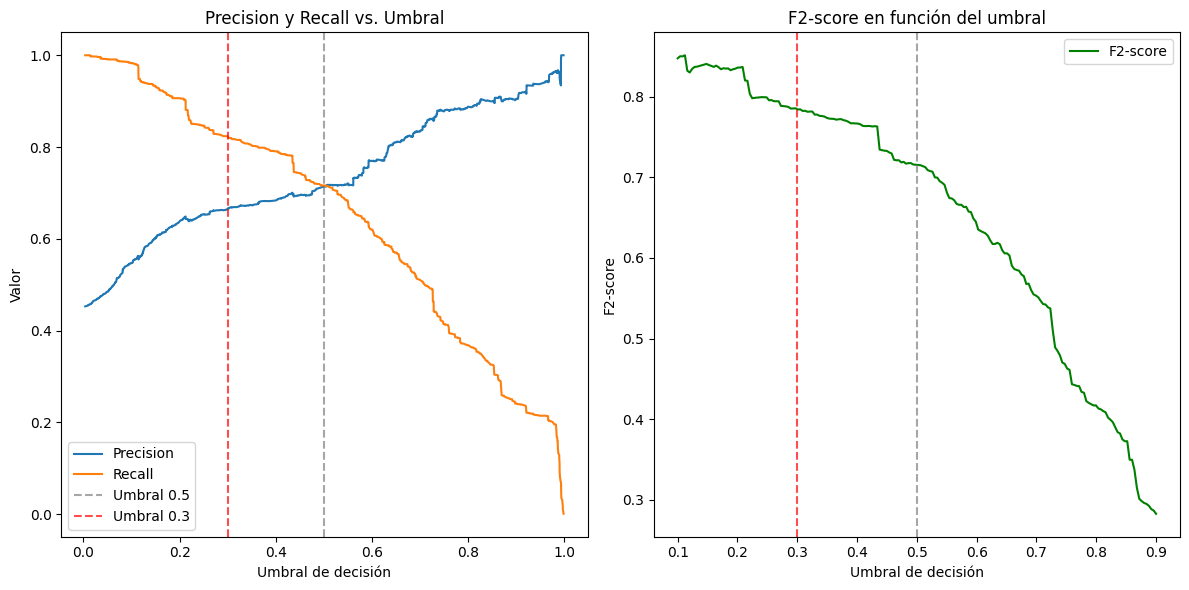

In [100]:
# Calcular probabilidades
y_scores = pipe_final.predict_proba(X_test_pred)[:, 1]

# Umbrales y F2-score
thresholds = np.linspace(0.1, 0.9, 200)
fbeta_scores = []

for t in thresholds:
    y_pred_thresh = (y_scores >= t).astype(int)
    f2 = fbeta_score(y_test, y_pred_thresh, beta=2)
    fbeta_scores.append(f2)

# Curvas de precision y recall
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, y_scores)

# Gráficos
plt.figure(figsize=(12, 6))

# Precision y Recall
plt.subplot(1, 2, 1)
plt.plot(threshold_curve, precision_curve[:-1], label='Precision')
plt.plot(threshold_curve, recall_curve[:-1], label='Recall')
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.7, label='Umbral 0.5')
plt.axvline(0.3, color='red', linestyle='--', alpha=0.7, label='Umbral 0.3')
plt.xlabel('Umbral de decisión')
plt.ylabel('Valor')
plt.title('Precision y Recall vs. Umbral')
plt.legend()

# F2-score
plt.subplot(1, 2, 2)
plt.plot(thresholds, fbeta_scores, label='F2-score', color='green')
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.7)
plt.axvline(0.3, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Umbral de decisión')
plt.ylabel('F2-score')
plt.title('F2-score en función del umbral')
plt.legend()

plt.tight_layout()
plt.show()

Este gráfico permite argumentar con datos que un umbral de 0.3 es óptimo para contextos de cribado toxicológico, donde evitar falsos negativos es prioritario.
A la vez, permite al usuario ajustar el umbral según su nivel de tolerancia al riesgo, lo que otorga flexibilidad y madurez al sistema predictivo.

## 5.4  Conclusiones del modelo final

Tras comparar múltiples modelos con diferentes arquitecturas y ajustes, se ha seleccionado como modelo final una **Regresión Logística con ajuste de hiperparámetros**, debido a los siguientes motivos:

- **Rendimiento consistente y competitivo**:
  - F1-score promedio en validación cruzada (folds ADORE): **0.74**
  - F1-score en test (compuestos no vistos): **0.715**

- **Estabilidad entre folds**, con menor varianza respecto a Random Forest o XGBoost, lo que sugiere una mayor robustez.

- **Mejor interpretabilidad**, lo que favorece su uso en contextos regulatorios y científicos.

- **Menor riesgo de sobreajuste**, a pesar de ser un modelo lineal, se comporta de forma balanceada entre sensibilidad y precisión.

Aunque modelos como Random Forest o XGBoost podrían ser más expresivos, **no lograron superar al baseline** en condiciones comparables. Por ello, y dado el objetivo del proyecto (construir una primera herramienta fiable y ética para predicción de toxicidad), la Regresión Logística ajustada se considera la mejor elección actual.

## 5.5 Guardado del modelo
Una vez seleccionados los mejores hiperparámetros a partir de la validación cruzada con los folds oficiales (ADORE), se ha reentrenado el pipeline completo (preprocesador + modelo) usando todo el conjunto `trainval`.

Este pipeline ha sido guardado como modelo final para futuras predicciones o despliegue, garantizando:

- Reproducibilidad completa del flujo
- Consistencia en el preprocesado
- Aprovechamiento de todos los datos disponibles

In [83]:
print("Dimensiones del conjunto de entrenamiento:", X_train_pred.shape, y_train.shape)
print("Modelo entrenado:", pipe_final.named_steps['classifier'])

Dimensiones del conjunto de entrenamiento: (21981, 26) (21981,)
Modelo entrenado: LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='liblinear')


In [84]:
# Guardar el pipeline entrenado con hiperparámetros ajustados
joblib.dump(pipe_final, "../../models/modelo_final_logreg_tuning.joblib")
print("Modelo final guardado en: models/modelo_final_logreg_tuning.joblib")

Modelo final guardado en: models/modelo_final_logreg_tuning.joblib


## 5. 6 Interpretacion del modelo 
[Indice](#indice)

### Importancia de coeficientes
Como el modelo seleccionado es una Regresión Logística, la interpretación de los coeficientes es directa: cada valor indica el impacto (positivo o negativo) de una variable en la probabilidad de que una sustancia sea clasificada como **tóxica** (`1`).

A continuación se muestran las 15 variables con mayor influencia positiva y negativa, respectivamente.

In [85]:
def get_feature_names(column_transformer):
    """
    Extrae los nombres de las variables resultantes tras aplicar un ColumnTransformer,
    incluyendo pipelines anidados (como escalado u OneHotEncoder), en el orden en que
    aparecen en el array de entrada del modelo.

    Args:
        column_transformer (ColumnTransformer): transformador de columnas entrenado.

    Returns:
        list: lista de nombres de variables transformadas.
    """
    feature_names = []

    for name, transformer, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue  # ignorar columnas que se dejan sin transformar

        # Si hay pipeline interno (e.g., scaler + encoder), extraer último paso
        if isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
        else:
            last_step = transformer

        try:
            names = last_step.get_feature_names_out(cols)
        except AttributeError:
            names = cols  # fallback si el transformador no implementa este método

        feature_names.extend(names)

    return feature_names


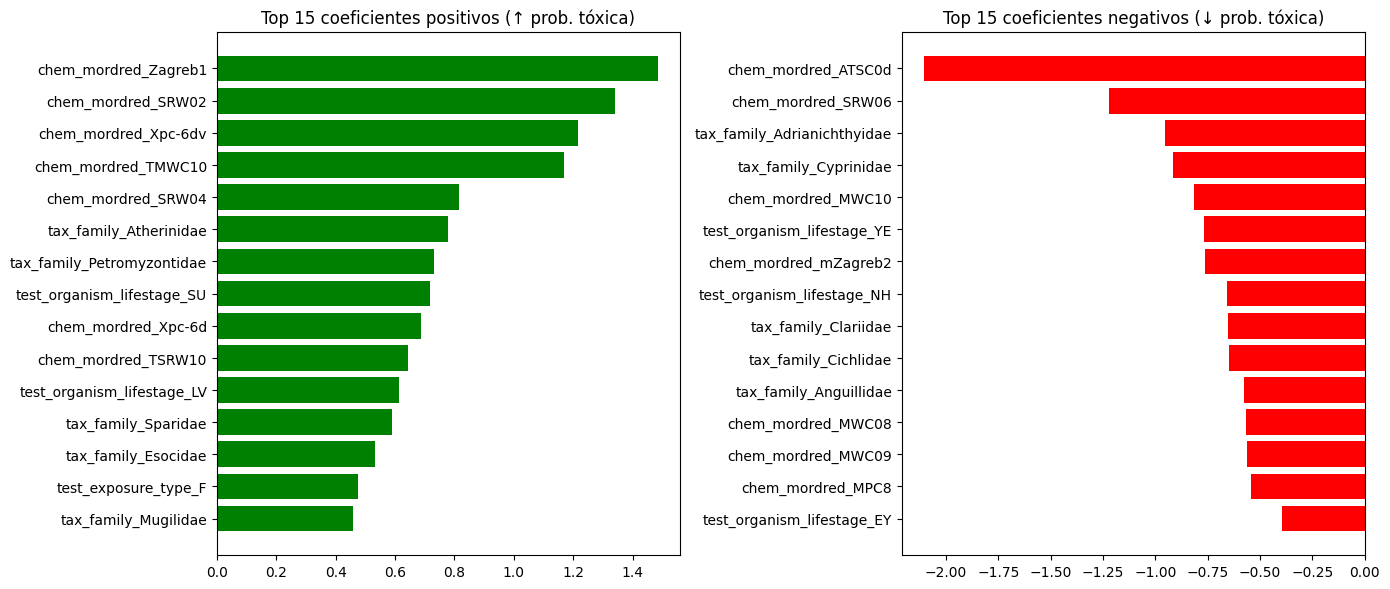

In [86]:
# Extraer el clasificador del pipeline
clf = pipe_final.named_steps['classifier']
coefs = clf.coef_[0]  # vector 1D con coeficientes

# Obtener los nombres de features transformados
feature_names = get_feature_names(pipe_final.named_steps['preprocessor'])

# Asociar coeficientes con nombres
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs
})

# Ordenar por valor absoluto
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df_sorted = coef_df.sort_values('abs_coef', ascending=False)

# Visualizar top 15 positivos y negativos
top_pos = coef_df[coef_df['coef'] > 0].sort_values('coef', ascending=False).head(15)
top_neg = coef_df[coef_df['coef'] < 0].sort_values('coef', ascending=True).head(15)

# Gráfico
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(top_pos['feature'], top_pos['coef'], color='green')
axes[0].set_title("Top 15 coeficientes positivos (↑ prob. tóxica)")
axes[0].invert_yaxis()

axes[1].barh(top_neg['feature'], top_neg['coef'], color='red')
axes[1].set_title("Top 15 coeficientes negativos (↓ prob. tóxica)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

- Coeficientes **positivos** (verde): aumentan la probabilidad de que una sustancia sea clasificada como **tóxica** (`1`).
- Coeficientes **negativos** (rojo): reducen esa probabilidad, asociándose a clasificaciones como **no tóxicas** (`0`).

#### Variables más influyentes

Entre las variables más influyentes se encuentran:

- **Descriptores moleculares** como `Zagreb1`, `SRW02` o `Xpc-6dv`, que capturan propiedades químicas complejas relacionadas con la reactividad o estructura.
- **Familias taxonómicas** (`Atherinidae`, `Petromyzontidae`, `Adrianichthyidae`, etc.) que podrían reflejar diferencias fisiológicas en la sensibilidad al compuesto.
- **Fase de vida del organismo de test** (`lifestage_SU`, `YE`, `EY`...), lo que refuerza la importancia del contexto biológico del ensayo.


> Esta interpretación no solo valida que el modelo aprende patrones significativos, sino que también permite generar hipótesis biológicas o químicas sobre los factores que determinan la toxicidad.

---

# 6 Integracion de features contextuales
[Indice](#indice)

### Objetivo

Incorporar features contextuales al modelo final para evaluar si aportan valor predictivo adicional.

## 6.1 Selección de features contextuales

In [87]:
# Separar predictivas y contextuales
vars_predictivas = df_features.query("Tipo == 'predictiva'")["Variable"].tolist()
vars_contextuales = df_features.query("Tipo == 'contextual'")["Variable"].tolist()

# Combinar para el nuevo modelo enriquecido
vars_completo = vars_predictivas + vars_contextuales

## 6.2 Entrenamiento con las nuevas variables

In [88]:
# Conjuntos de train y test actualizados
X_train_full = df_trainval[vars_completo].copy()
y_train = df_trainval[target].copy()

X_test_full = df_test[vars_completo].copy()
y_test = df_test[target].copy()

# Reutilizamos hiperparámetros ya ajustados
logreg_contextual = LogisticRegression(C=0.1, solver='liblinear', max_iter=1000, random_state=42)

pipe_contextual = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', logreg_contextual)
])

pipe_contextual.fit(X_train_full, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log_scaled',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['chem_mordred_ATS3Z',
                                                   'chem_mordred_MPC8',
                                                   'chem_mordred_ATS0m',
                                                   'chem_mordred_SRW06',
                                                   'chem_mordred_Xpc-6d',
                                                   'chem_mordred_Xpc-5dv',
                                                   'chem_mordred_Xpc-6dv']),
                                                 ('scaled'...
                                                   'chem_mordred_mZagreb2',
                                                   'chem_mordred_SRW02',
                                                   'chem_mordred_ATSC0d',
                                                   'chem_mordred_MWC08',
                                                   'chem_mordred_GGI2',
                                                   'chem_mol2vec057']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['test_exposure_type',
                                                   'test_organism_lifestage',
                                                   'result_endpoint',
                                                   'tax_family',
                                                   'tax_eco_migrate2'])])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=42,
                                    solver='liblinear'))])

## 6.3 Evaluacion del modelo enriquecido

Evaluación con features contextuales:
Accuracy: 0.742
Recall:   0.716
F1 Score: 0.715


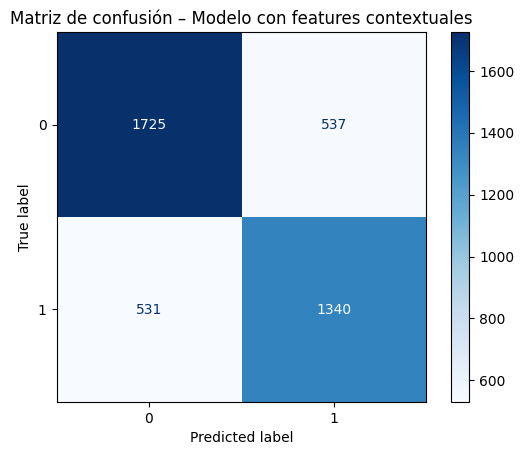

In [89]:
# Predicciones y métricas
y_pred_contextual = pipe_contextual.predict(X_test_full)

print("Evaluación con features contextuales:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_contextual):.3f}")
print(f"Recall:   {recall_score(y_test, y_pred_contextual):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_contextual):.3f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_contextual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión – Modelo con features contextuales")
plt.show()


## 6.4 Evaluacion con variables contextuales

Como paso final de mejora, se integraron al modelo varias variables contextuales adicionales:
- Parámetros ambientales (`media_ph_mean`, `media_temperature_mean`)
- Información taxonómica y ecológica (`tax_lh_*`)
- Variables adicionales de ensayo

Estas variables fueron añadidas a las predictivas ya existentes, y el modelo fue reentrenado completamente.

**Conclusión:** Las variables contextuales, en este caso, **no mejoraron el rendimiento** del modelo en el set de test. Esto podría deberse a varias razones:

- Ya existe suficiente información en los descriptores moleculares y taxonómicos básicos
- Las variables contextuales no están bien representadas o normalizadas
- La regresión logística podría no capturar relaciones no lineales entre estas variables y el target

No obstante, esta integración refuerza la trazabilidad del modelo y su validez en términos regulatorios, mostrando que se han explorado múltiples dimensiones del problema.

----

# 7 Interpretacion del modelo con SHAP
[Indice](#indice)

Para complementar la interpretación basada en coeficientes, se utilizó el método SHAP (SHapley Additive exPlanations), ampliamente reconocido como una de las técnicas más sólidas para explicar modelos de Machine Learning.

Aunque el modelo final es una regresión logística (modelo lineal), SHAP permite:

- Medir la contribución individual de cada variable a cada predicción
- Comparar la importancia relativa de las variables en el conjunto de test
- Visualizar interacciones y variabilidad entre muestras

## 7.1 Summary plot

A continuación, se muestra el gráfico `summary_plot`, que resume la importancia y dirección del efecto de cada feature sobre las predicciones.

In [90]:
# Aplicar solo el preprocesador al test
X_test_transformed = pipe_final.named_steps["preprocessor"].transform(X_test_pred)

# Obtener nombres de features transformadas
feature_names_transformed = get_feature_names(pipe_final.named_steps["preprocessor"])

In [91]:
# Extraer el clasificador entrenado
clf_final = pipe_final.named_steps["classifier"]

# Crear explainer (se asume modelo lineal)
explainer = shap.LinearExplainer(clf_final, X_test_transformed, feature_perturbation="interventional")

# Se usaLinearExplainer porque el modelo elegido es una regresión logística

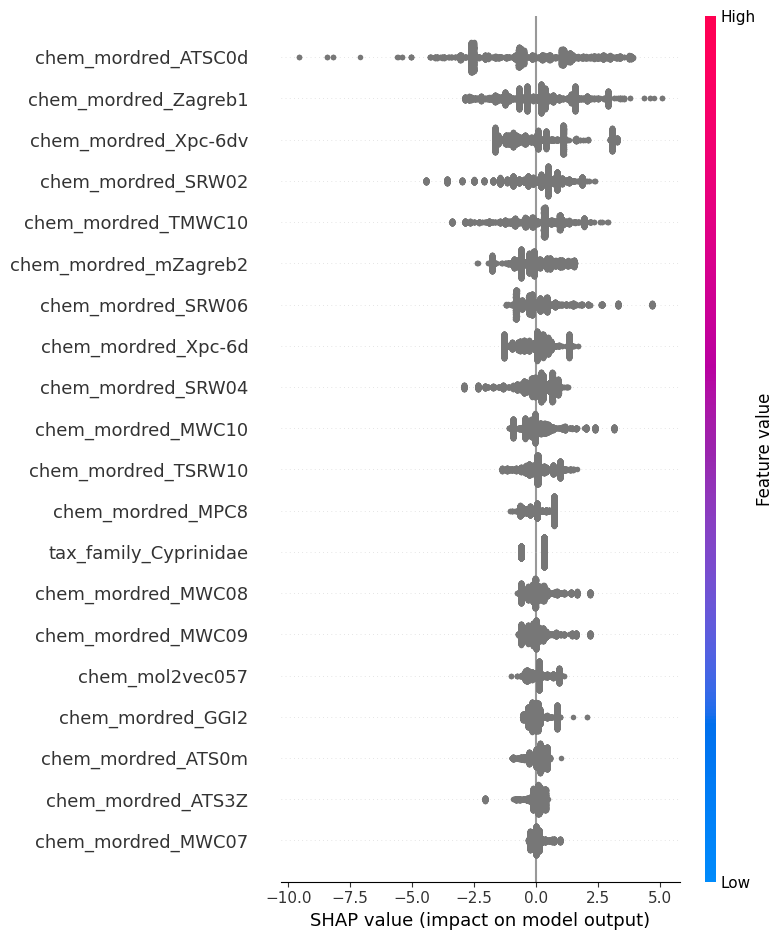

In [92]:
# Calcular los SHAP values sobre el test transformado
shap_values = explainer.shap_values(X_test_transformed)

# Convertimos a DataFrame para visualizar mejor
df_shap = pd.DataFrame(shap_values, columns=feature_names_transformed)

# Visualización resumen
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names_transformed)

### Interpretación con SHAP – `summary_plot`

El gráfico SHAP generado sobre el set de test permite entender qué variables tienen mayor impacto sobre las predicciones del modelo y en qué dirección lo hacen.

#### Variables más influyentes

Las variables con mayor impacto en la predicción de toxicidad (tanto positiva como negativa) son:

- **chem_mordred_ATSC0d**  
- **chem_mordred_Zagreb1**  
- **chem_mordred_Xpc-6dv**  
- **chem_mordred_SRW02**  
- **chem_mordred_TMWC10**

Estas variables químicas aparecen consistentemente como relevantes tanto en el análisis de coeficientes como en el de SHAP, lo que refuerza su importancia.

#### ¿Qué muestra el gráfico?

- El **eje horizontal** muestra el impacto de cada variable en la salida del modelo (positiva -> más probable tóxica)
- Cada punto representa una observación del test set
- El **color** representa el valor de la feature (azul = bajo, rosa = alto)

Por ejemplo:

- En **chem_mordred_ATSC0d**, valores bajos están asociados con mayor probabilidad de predicción positiva (tóxica), mientras que valores altos empujan la predicción hacia no tóxica.
- En **Zagreb1**, ocurre lo contrario: valores altos tienen efecto positivo sobre la probabilidad de toxicidad.

#### Conclusión

SHAP confirma los hallazgos del análisis de coeficientes y aporta una capa adicional de explicabilidad a nivel individual. Aunque el modelo es lineal, se observan interacciones sutiles y efectos diferenciados según el valor de cada variable, lo que refuerza la utilidad del análisis SHAP como herramienta complementaria.

Este tipo de análisis puede ser muy útil en contextos regulatorios donde se requiere justificar las predicciones del modelo con base en variables específicas.

## 7.2 Force plot
SU objetivo es mostrar, para un caso específico, qué variables empujan la predicción hacia "tóxica" (clase 1) o hacia "no tóxica" (clase 0), y en qué magnitud.


In [93]:
# Seleccionar un índice del test (puedes cambiarlo)
idx = 42

# Datos crudos (sin transformar, para mostrar si se quiere)
X_instance_raw = X_test_pred.iloc[idx]

# Datos transformados (como los ve el modelo)
X_instance_transformed = X_test_transformed[idx]

X_instance_dense = X_instance_transformed.toarray()

In [94]:
# Calcular valores SHAP individuales
shap_value_instance = explainer.shap_values(X_instance_transformed)

# Mostrar force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_value_instance,
    X_instance_dense,
    feature_names=feature_names_transformed
)

### Explicación individual – `force_plot`

Además del análisis global de importancia de variables, se utilizó un gráfico `force_plot` para examinar cómo el modelo toma decisiones en un caso específico.

Este gráfico permite visualizar:

- Qué variables empujan la predicción hacia un resultado **positivo (tóxica)** o **negativo (no tóxica)**
- La magnitud e impacto de cada variable en la decisión final
- El valor base del modelo (`expected value`) y cómo se ajusta con las contribuciones individuales

#### Caso seleccionado

Se analizó una muestra individual del conjunto de test (`instance 42`). El gráfico resultante fue guardado como archivo HTML interactivo.

> Este archivo puede abrirse en cualquier navegador para explorar la explicación de forma dinámica.

Este tipo de visualización resulta especialmente útil en contextos donde se requiere trazabilidad y justificación clara del comportamiento del modelo ante cada predicción.


In [95]:
# Crear el force_plot
force_plot_html = shap.force_plot(
    explainer.expected_value,
    shap_value_instance,
    X_instance_dense,
    feature_names=feature_names_transformed
)

# Guardar en archivo HTML interactivo
shap.save_html("../img/force_plot_instance42.html", force_plot_html)

# Gráficos presentación

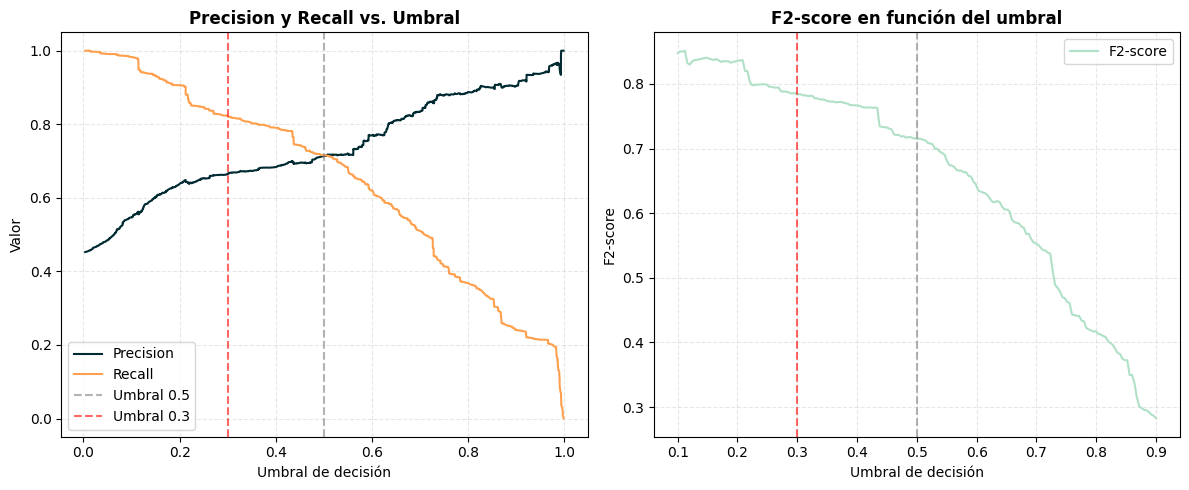

In [ ]:
# Obtener probabilidades del modelo
y_scores = pipe_final.predict_proba(X_test_pred)[:, 1]

# Umbrales
thresholds = np.linspace(0.1, 0.9, 200)

# Calcular F2 para cada umbral
f2_scores = [
    fbeta_score(y_test, (y_scores >= t).astype(int), beta=2)
    for t in thresholds
]

# Curvas de precision y recall
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, y_scores)

# Paleta Space
color_recall = '#FFA04E'
color_f2 = '#B0E0C6'
color_precision = '#002A32'

# Gráfico doble
plt.figure(figsize=(12, 5))

# Plot Precision y Recall
plt.subplot(1, 2, 1)
plt.plot(threshold_curve, precision_curve[:-1], label='Precision', color=color_precision)
plt.plot(threshold_curve, recall_curve[:-1], label='Recall', color=color_recall)
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.6, label='Umbral 0.5')
plt.axvline(0.3, color='red', linestyle='--', alpha=0.6, label='Umbral 0.3')
plt.title("Precision y Recall vs. Umbral", fontsize=12, fontweight='bold')
plt.xlabel("Umbral de decisión")
plt.ylabel("Valor")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

# Plot F2-score
plt.subplot(1, 2, 2)
plt.plot(thresholds, f2_scores, color=color_f2, label='F2-score')
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.6)
plt.axvline(0.3, color='red', linestyle='--', alpha=0.6)
plt.title("F2-score en función del umbral", fontsize=12, fontweight='bold')
plt.xlabel("Umbral de decisión")
plt.ylabel("F2-score")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


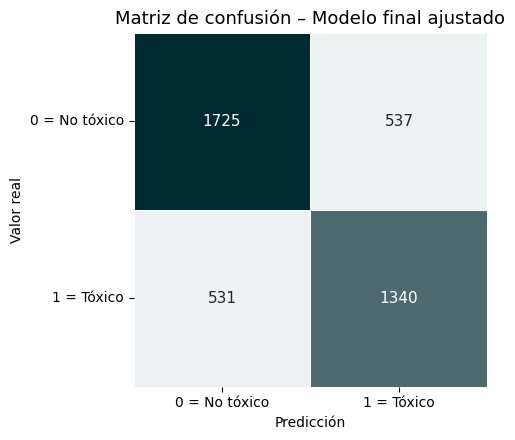

In [106]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Paleta Space personalizada (azul marino)
cmap = sns.light_palette("#002A32", reverse=False, as_cmap=True)

# Gráfico
plt.figure(figsize=(5.5, 4.5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=cmap,
    cbar=False,
    square=True,
    annot_kws={"fontsize": 11},
    linewidths=0.5,
    linecolor='white'
)
plt.title("Matriz de confusión – Modelo final ajustado", fontsize=13)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.xticks([0.5, 1.5], ['0 = No tóxico', '1 = Tóxico'], rotation=0)
plt.yticks([0.5, 1.5], ['0 = No tóxico', '1 = Tóxico'], rotation=0)
plt.tight_layout()
plt.show()


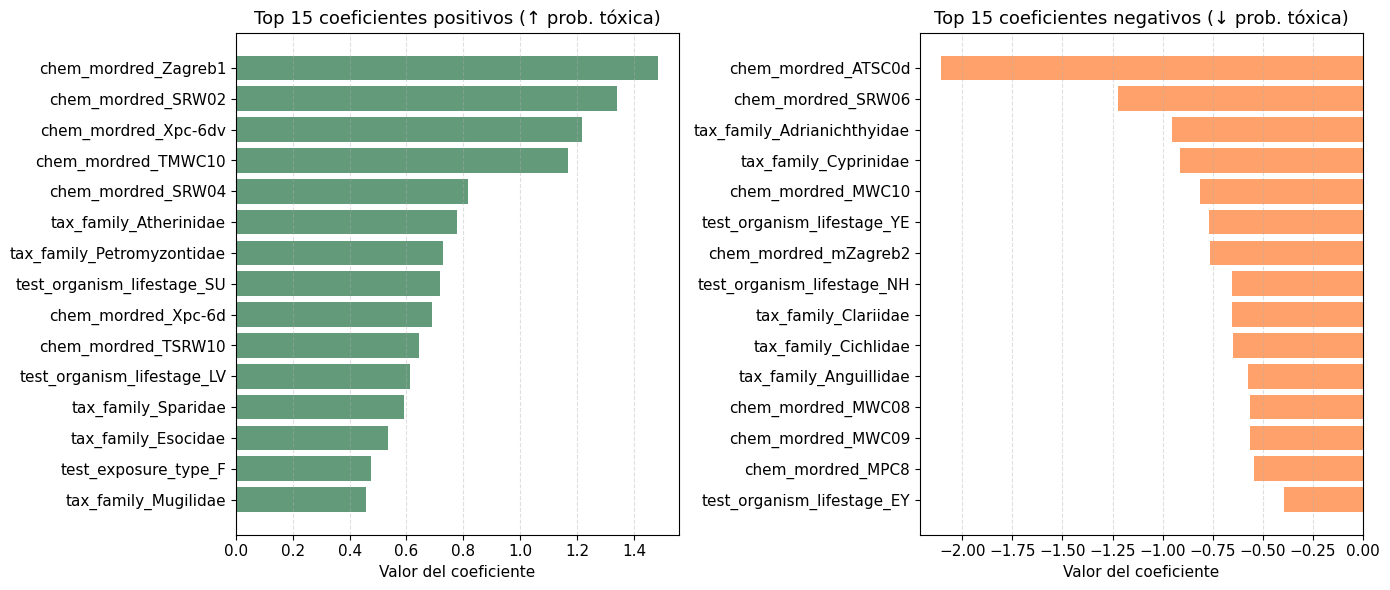

In [105]:
# Extraer el clasificador del pipeline
clf = pipe_final.named_steps['classifier']
coefs = clf.coef_[0]  # vector 1D con coeficientes

# Obtener los nombres de features transformadas
feature_names = get_feature_names(pipe_final.named_steps['preprocessor'])

# Asociar coeficientes con nombres
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs
})

# Ordenar por valor absoluto
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df_sorted = coef_df.sort_values('abs_coef', ascending=False)

# Visualizar top 15 positivos y negativos
top_pos = coef_df[coef_df['coef'] > 0].sort_values('coef', ascending=False).head(15)
top_neg = coef_df[coef_df['coef'] < 0].sort_values('coef', ascending=True).head(15)

# Colores Space
verde_menta = "#629A7A"
naranja = '#FFA16A'

# Gráfico
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Positivos (↑ prob. tóxica)
axes[0].barh(top_pos['feature'], top_pos['coef'], color=verde_menta)
axes[0].set_title("Top 15 coeficientes positivos (↑ prob. tóxica)", fontsize=13)
axes[0].invert_yaxis()

# Negativos (↓ prob. tóxica)
axes[1].barh(top_neg['feature'], top_neg['coef'], color=naranja)
axes[1].set_title("Top 15 coeficientes negativos (↓ prob. tóxica)", fontsize=13)
axes[1].invert_yaxis()

# Estética
for ax in axes:
    ax.tick_params(axis='both', labelsize=11)
    ax.set_xlabel("Valor del coeficiente", fontsize=11)
    ax.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

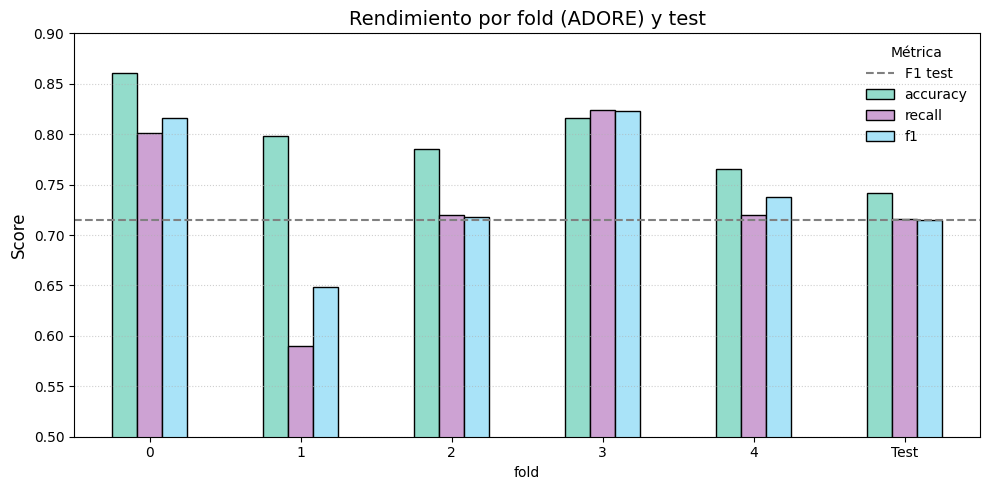

In [112]:
# Paleta Space adaptada
color_accuracy = "#93DCCB"   # naranja suave
color_recall   = "#CDA2D3"   # azul menta
color_f1       = "#A9E3F8"   # azul marino (más oscuro para F1)

# Crear copia extendida con los valores del test
df_plot = df_cv_adore.copy()
df_plot.loc[len(df_plot)] = ['Test', 
                             accuracy_score(y_test, y_pred),
                             recall_score(y_test, y_pred),
                             f1_score(y_test, y_pred)]

# Convertir fold a string para visualización
df_plot['fold'] = df_plot['fold'].astype(str)

# Gráfico con colores personalizados
fig, ax = plt.subplots(figsize=(10, 5))
df_plot_plot = df_plot.set_index('fold')[['accuracy', 'recall', 'f1']]

df_plot_plot.plot(
    kind='bar',
    ax=ax,
    color=[color_accuracy, color_recall, color_f1],
    edgecolor='black'
)

# Títulos y ejes
ax.set_title("Rendimiento por fold (ADORE) y test", fontsize=14)
ax.set_ylabel("Score", fontsize=12)
ax.set_ylim(0.5, 0.9)
ax.axhline(
    y=df_plot[df_plot['fold'] == 'Test']['f1'].values[0],
    color='gray', linestyle='--', linewidth=1.5, label='F1 test'
)

# Leyenda y estilo
ax.legend(title="Métrica", loc='upper right', frameon=False)
ax.grid(axis='y', linestyle=':', alpha=0.6)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
